# Import libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances_argmin_min

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM

import time

from collections import Counter


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(42)

# Task 1:  Dataset Characterization and Preprocessing

## Dataset exploration

Initial shape: (18831, 43)
final shape: (18831, 43)
=== DATASET GENERAL INFORMATION ===
Dataset dimension: (18831, 43)
Number of rows: 18831
Number of columns: 43


=== DATASET STRUCTURE ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18831 entries, 0 to 18830
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     18831 non-null  int64  
 1   protocol_type                18831 non-null  object 
 2   service                      18831 non-null  object 
 3   flag                         18831 non-null  object 
 4   src_bytes                    18831 non-null  int64  
 5   dst_bytes                    18831 non-null  int64  
 6   land                         18831 non-null  int64  
 7   wrong_fragment               18831 non-null  int64  
 8   urgent                       18831 non-null  int64  
 9   hot                          18831 non-null  int64  
 10 

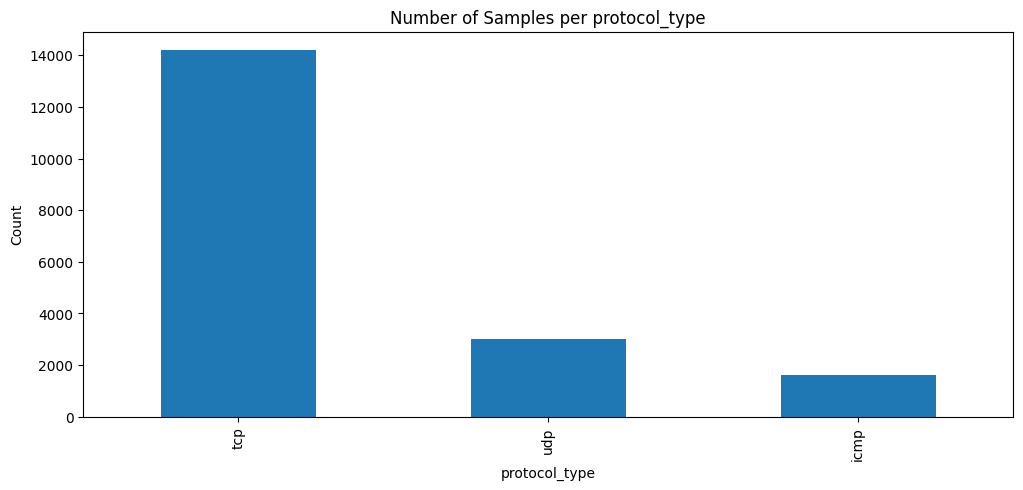

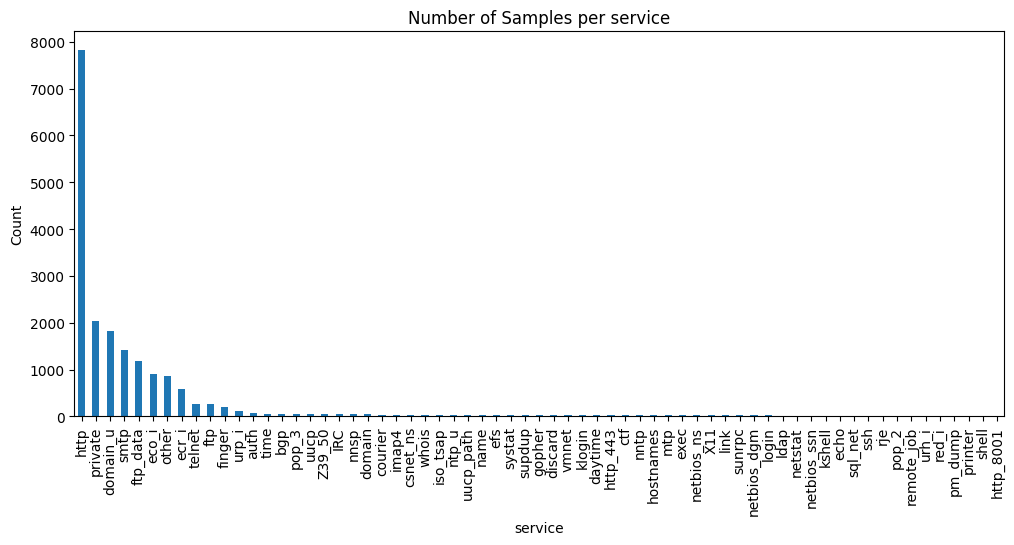

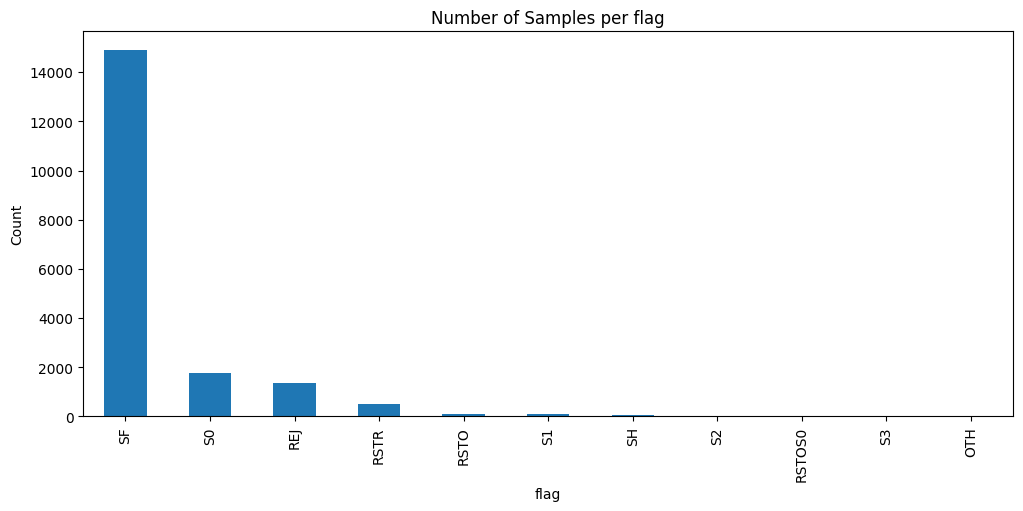

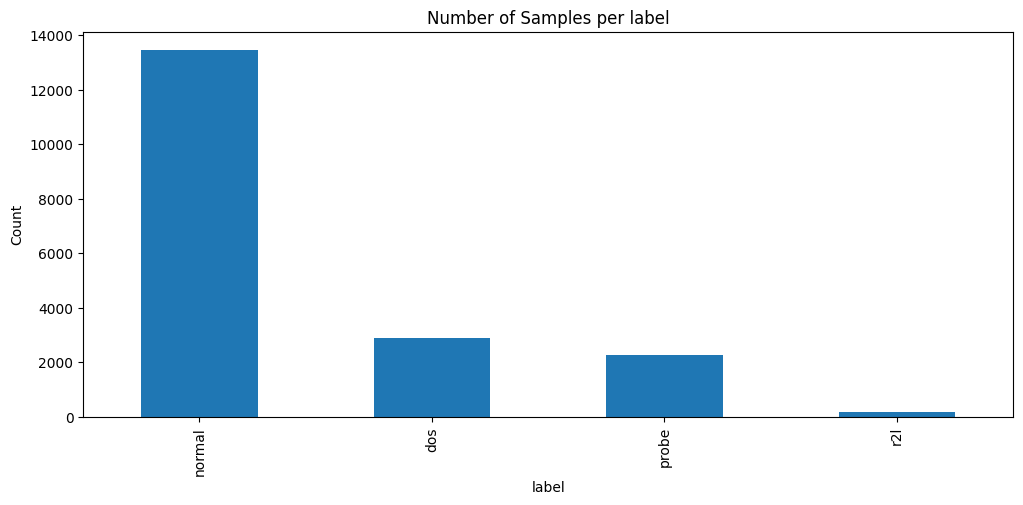

=== BINARY LABEL ===


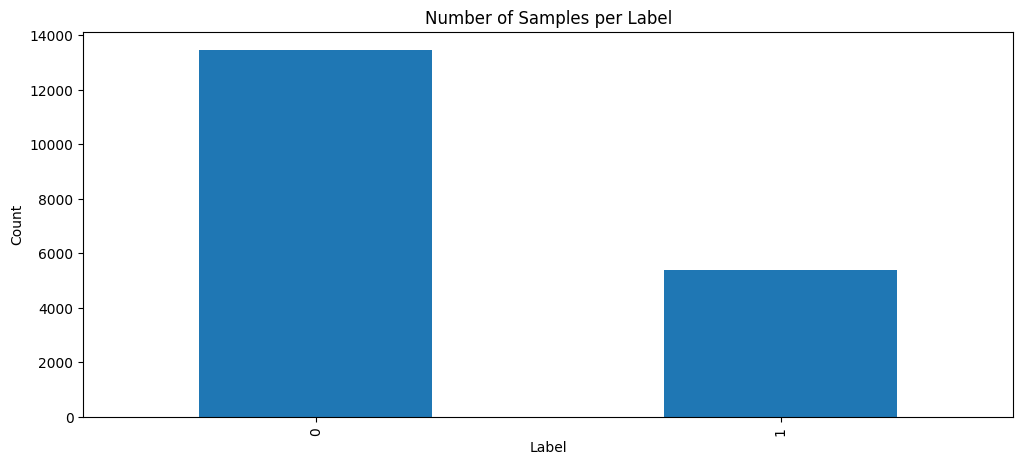

In [ ]:
df_train = pd.read_csv(f'/content/train.csv')
df_test = pd.read_csv(f'/content/test.csv')

# Display basic info
print("Initial shape:", df_train.shape)

# Data Cleaning
# Drop duplicate rows
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", df_train.shape)

# general informations
print("=== DATASET GENERAL INFORMATION ===")
print(f"Dataset dimension: {df_train.shape}")
print(f"Number of rows: {df_train.shape[0]}")
print(f"Number of columns: {df_train.shape[1]}")
print("\n")

# Column names and data types
print("=== DATASET STRUCTURE ===")
print(df_train.info())
print("\n")

# ategorical vs numerical
print("=== CATEGORICAL VS NUMERICAL ===")
categorical_cols = df_train.select_dtypes(include=['object']).columns
numerical_cols = df_train.select_dtypes(include=[np.number]).columns

print(f"Categorical columns ({len(categorical_cols)}): {list(categorical_cols)}")
print(f"Numerical columns ({len(numerical_cols)}): {list(numerical_cols)}")
print("\n")

# Label distribution
print("=== LABEL DISTRIBUTION ===")
label_distribution = df_train['label'].value_counts()
print(label_distribution)
print("\n")

print("Binary_label distribution:")
binary_distribution = df_train['binary_label'].value_counts()
print(binary_distribution)
print("\n")

# Percentages of label
print("=== PERCENTUALS OF LABELS ===")
print("Labels (%):")
print((df_train['label'].value_counts(normalize=True) * 100).round(2))
print("\n")

print("Binary label (%):")
print((df_train['binary_label'].value_counts(normalize=True) * 100).round(2))
print("\n")

# Visualizations
print("=== DISTRIBUTION OF CATEGORICAL FEATURES ===")

for col in categorical_cols:
  df_train[col].value_counts().plot(kind="bar", figsize=(12, 5))
  plt.title("Number of Samples per " + col)
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.xticks(rotation=90)
  plt.show()
  plt.close()

# Define the allowed list of services
allowed_services = ["http", "private", "domain_u","smtp","ftp_data", "eco_i" ,"other",  "ecr_i", "telnet" ,"ftp","finger"]
df_train["service"] = df_train["service"].apply(lambda x: x if x in allowed_services else "other")
df_test["service"] = df_test["service"].apply(lambda x: x if x in allowed_services else "other")

# Define the allowed list of services
allowed_flag = ["SF", "S0", "REJ", "RSTR"]
# Apply the mapping
df_train["flag"] = df_train["flag"].apply(lambda x: x if x in allowed_flag else "other")
df_test["flag"] = df_test["flag"].apply(lambda x: x if x in allowed_flag else "other")

print("=== BINARY LABEL ===")
# Label distribution

df_train["binary_label"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()



In [ ]:
# Set up column groups
ignore_cols = ['label', 'binary_label']  # columns to skip entirely
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in df_train.columns if col not in categorical_cols + ignore_cols]

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # drop columns not listed (i.e., ignore_cols)
)

# Fit on training, transform all splits
X_train_transformed = preprocessor.fit_transform(df_train)
X_test_transformed  = preprocessor.transform(df_test)

# Get transformed feature names and make DataFrames
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

df_train_preprocessed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
df_test_preprocessed  = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Restore the labels
df_train_preprocessed["label"] = list(df_train["label"])
df_test_preprocessed["label"]  = list(df_test["label"])

df_train_preprocessed["binary_label"] = list(df_train["binary_label"])
df_test_preprocessed["binary_label"]  = list(df_test["binary_label"])

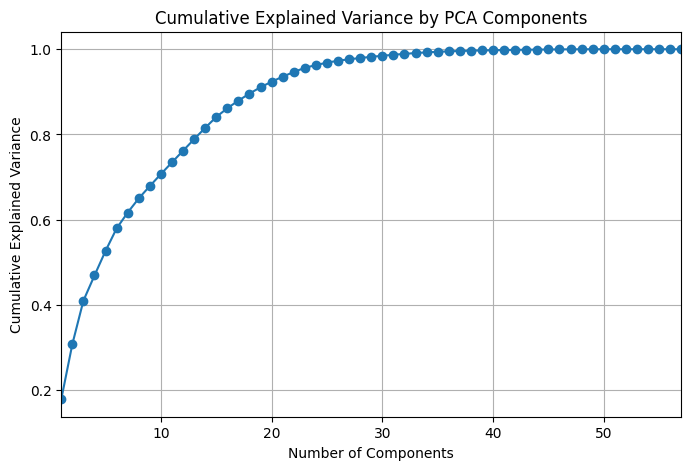

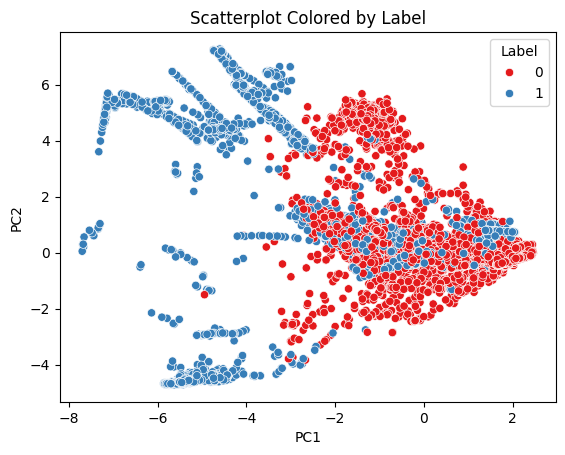

In [ ]:
def plot_pca(df):

    # Fit PCA with all components
    pca_full = PCA().fit(df.drop(columns=['label','binary_label']))

    # Plot explained variance ratio
    plt.figure(figsize=(8, 5))

    x = [i+1 for i in range(len(pca_full.explained_variance_ratio_))]
    y = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(x,y, marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.xlim(1,len(pca_full.explained_variance_ratio_))
    plt.grid(True)
    plt.show()
    plt.close()


    # Apply PCA to reduce to 2 components for KDE visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(columns=['label','binary_label']))
    labels = list(df['binary_label'])

    df_kde = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_kde['label'] = labels

    sns.scatterplot(data=df_kde, x='PC1', y='PC2', hue='label', palette='Set1')
    plt.title('Scatterplot Colored by Label')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Label')
    plt.show()
    plt.close()

    return


def plot_tsne(df, perplexity=30):

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, init='random')
    X_tsne = tsne.fit_transform(df.drop(columns=['label','binary_label']))
    labels = list(df['binary_label'])

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette='Set1', alpha=0.8
    )
    plt.title('2D t-SNE Projection')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label')
    plt.show()

    return


plot_pca(df_train_preprocessed)

In [ ]:
res = df_train_preprocessed.value_counts("binary_label")
anomaly_rate = res[1]/(res[0]+res[1])
print("The fraction of anomalies in the dataset is %.2f"%anomaly_rate)

The fraction of anomalies in the dataset is 0.29


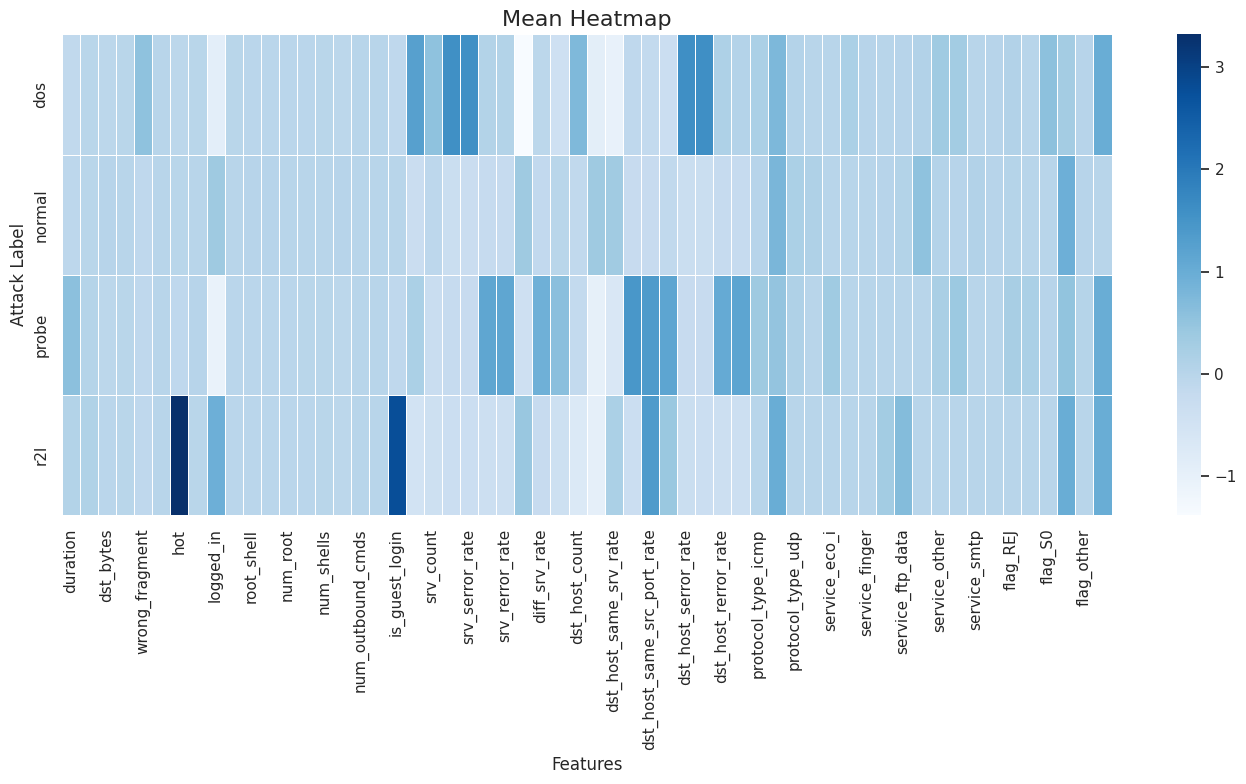

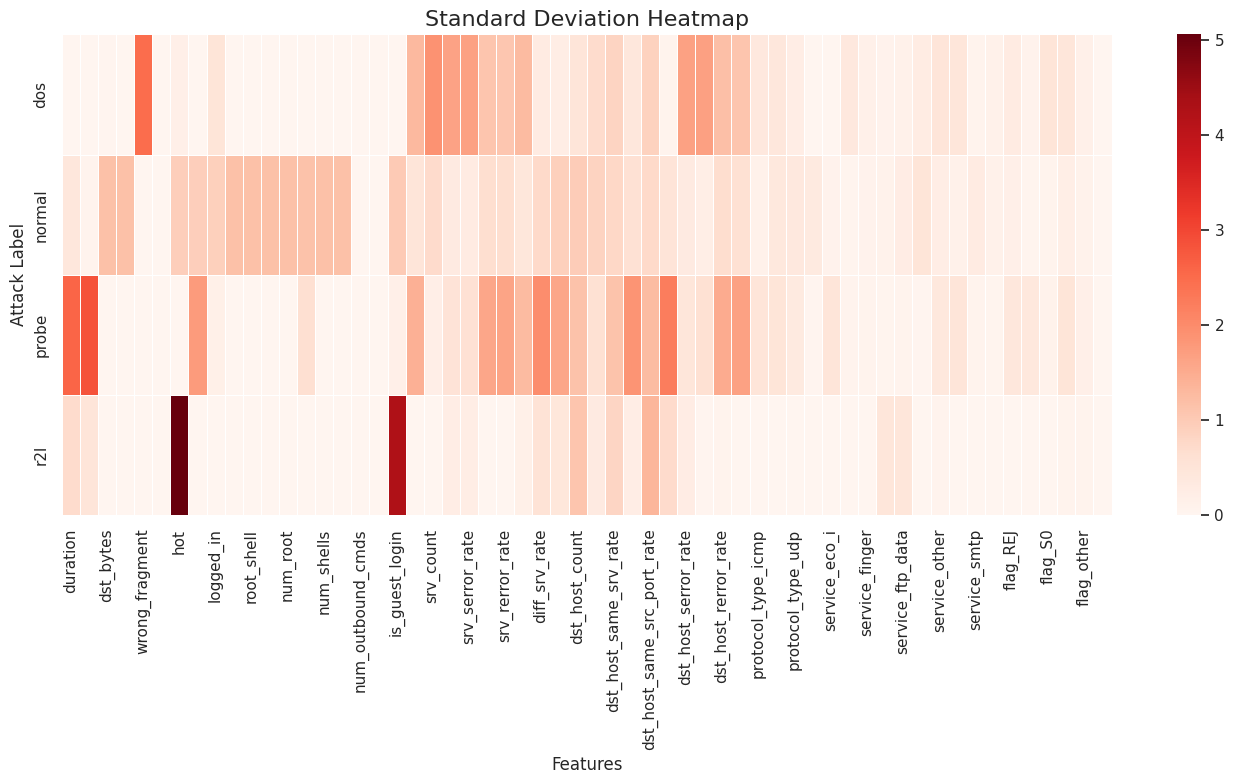

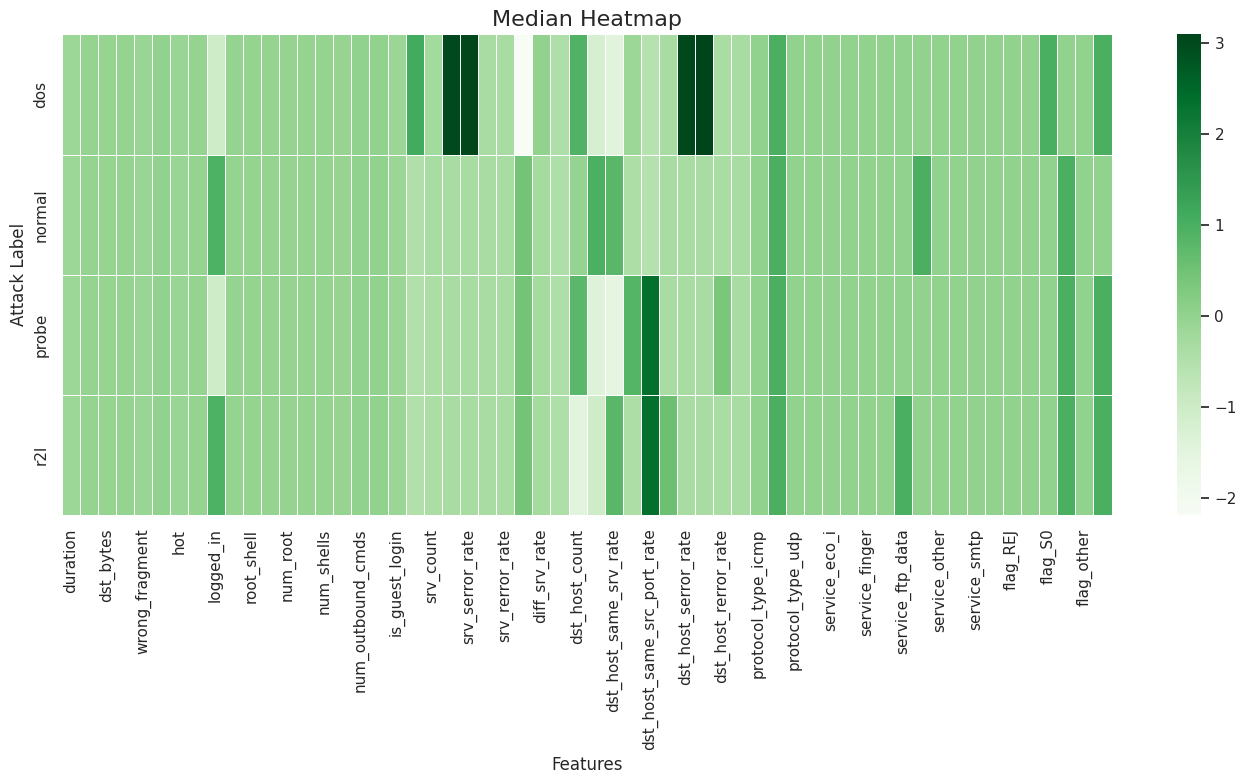

In [ ]:
df_analysis = df_train_preprocessed.copy()
target_col = 'label'

sns.set_theme(style="whitegrid")
df_mean = df_analysis.groupby(target_col).mean(numeric_only=True)
df_std = df_analysis.groupby(target_col).std(numeric_only=True)
df_median = df_analysis.groupby(target_col).median(numeric_only=True)

def plot_heatmap(data, title, cmap="viridis"):
    fig = plt.figure(figsize=(14, 8))
    sns.heatmap(data,
                annot=False,
                cmap=cmap,
                linewidths=0.5,
                fmt=".2f")
    plt.title(title, fontsize=16)
    plt.ylabel("Attack Label")
    plt.xlabel("Features")
    plt.tight_layout()
    plt.show()
    plt.close()

plot_heatmap(df_mean, "Mean Heatmap", cmap="Blues")
plot_heatmap(df_std, "Standard Deviation Heatmap", cmap="Reds")
plot_heatmap(df_median, "Median Heatmap", cmap="Greens")




In [ ]:

df_train_normal_only = df_train_preprocessed[df_train_preprocessed["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train_preprocessed.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train_preprocessed['label'])
y_train = list(df_train_preprocessed['binary_label'])

X_test = df_test_preprocessed.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test_preprocessed['label'])
y_test = list(df_test_preprocessed['binary_label'])

#Task 2:  Shallow Anomaly Detection- Supervised vs Unsupervised

In [ ]:
def plot_confusion_matrix(y_binary, y_pred, methodology, data_name):

    print("\nClassification Report (%s vs Ground Truth):", methodology)
    print(classification_report(y_binary, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_binary, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
    plt.title('Confusion Matrix %s with %s'%(data_name,methodology))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.close()

##Normal data only

One class svm with normal data only, with nu = 0.001 as there should be no anomalies



Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13448
           1       0.98      0.76      0.86      5383

    accuracy                           0.93     18831
   macro avg       0.95      0.88      0.90     18831
weighted avg       0.93      0.93      0.92     18831



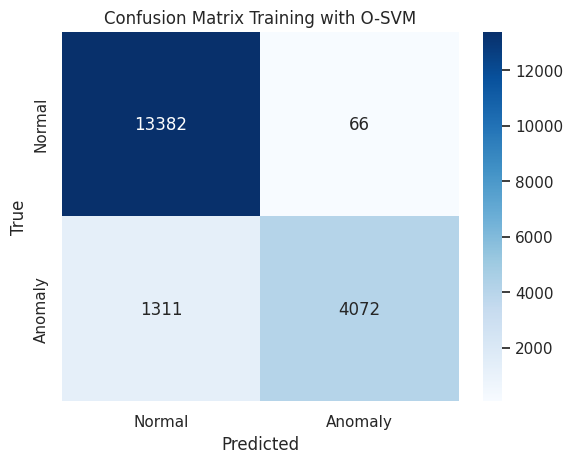

One class svm with normal data only, with default nu



Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.99      0.50      0.66     13448
           1       0.44      0.99      0.61      5383

    accuracy                           0.64     18831
   macro avg       0.72      0.74      0.64     18831
weighted avg       0.83      0.64      0.65     18831



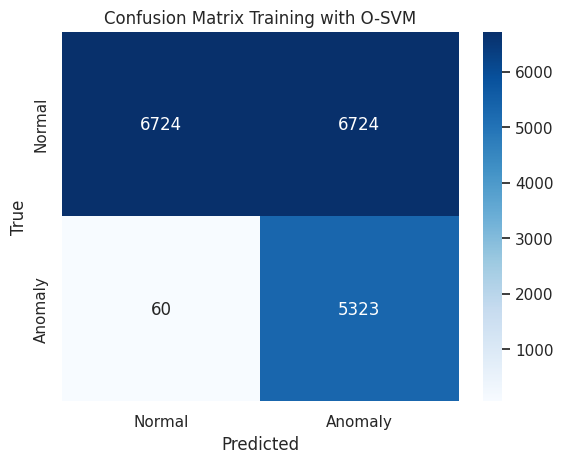

In [ ]:
# One class svm with normal data only, with nu = 0.001 as there should be no anomalies
print("="*50)
print("One class svm with normal data only, with nu = 0.001 as there should be no anomalies\n\n")
ocsvm_normal_only = OneClassSVM(kernel='rbf', gamma='scale', nu=0.001)
ocsvm_normal_only.fit(X_train_normal_only)

# Evaluate the performance using all training data (normal + anomalies)
# Use -1 for outliers
y_train_pred = ocsvm_normal_only.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)

f1_score_0 = f1_score(y_train, y_train_pred_binary, average="macro")
plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM", "Training")


# Now try with default nu
# One class svm with normal data only, with default nu
print(50*"=")
print("One class svm with normal data only, with default nu\n\n")
ocsvm_normal_only_default_nu = OneClassSVM(kernel='rbf', gamma='scale')
ocsvm_normal_only_default_nu.fit(X_train_normal_only)

# Evaluate the performance using all training data (normal + anomalies)
# Use -1 for outliers
y_train_pred = ocsvm_normal_only_default_nu.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)

plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM", "Training")

## All data

One class svm with normal data and anomalies



Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     13448
           1       0.63      0.63      0.63      5383

    accuracy                           0.79     18831
   macro avg       0.74      0.74      0.74     18831
weighted avg       0.79      0.79      0.79     18831



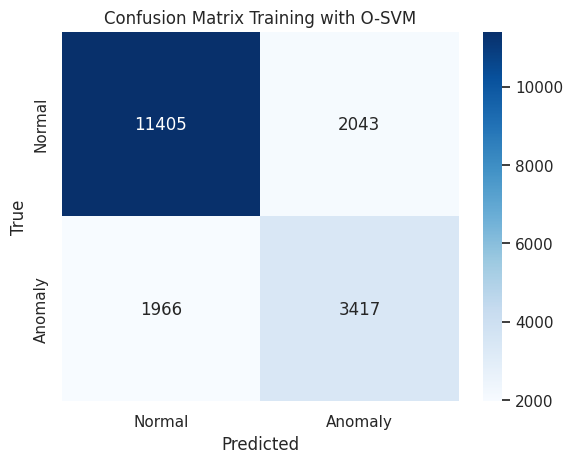

In [ ]:
# One class svm with normal data and anomalies
print("="*50)
print("One class svm with normal data and anomalies\n\n")
ocsvm_all_data = OneClassSVM(kernel='rbf', gamma='scale', nu=0.29)  # nu = estimated anomaly proportion
ocsvm_all_data.fit(X_train)

# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm_all_data.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)
f1_score_100 = f1_score(y_train, y_train_pred_binary, average="macro")

plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM", "Training")

## Increasing number of anomalies

In [ ]:
#separate normal and anomalies
df_norm = df_train_preprocessed[df_train_preprocessed["binary_label"] == 0].copy()
df_anom = df_train_preprocessed[df_train_preprocessed["binary_label"] == 1].copy()

#function to build the training set
def build_train_set(normal_df, anomaly_df, anomaly_fraction):
    # number of anomalies to include
    n_anom = int(len(anomaly_df) * anomaly_fraction)

    # downsample anomalies
    if n_anom > 0:
        sampled_anom = anomaly_df.sample(n=n_anom, random_state=42)
        df_result = pd.concat([normal_df, sampled_anom], axis=0)
    else:
        df_result = normal_df.copy()

    return df_result

# we already have ocsvm for 0% and 100%
fractions = {
    "10%" : 0.10,
    "20%" : 0.20,
    "50%" : 0.50
}

train_sets = {}

for name, frac in fractions.items():
    df_tmp = build_train_set(df_norm, df_anom, frac)
    train_sets[name] = df_tmp
    print(f"{name}: {df_tmp.shape[0]} samples, anomalies = {df_tmp['binary_label'].sum()}")

train_data = {}

for name, df_tmp in train_sets.items():
    X = df_tmp.drop(columns=["label", "binary_label"])
    y = np.array(df_tmp["binary_label"])
    train_data[name] = (X, y)

f1_macro_scores = {}
estimated_nus = {}
for name, (X_tr, y_tr) in train_data.items():
    estimated_nus[name] = y_tr.mean()

#define it separately, as we need to use it again
ocsvm10 = OneClassSVM(kernel='rbf', gamma='scale', nu=estimated_nus["10%"])

f1_macro_scores["0%"] = f1_score_0

for name, (X_tr, y_tr) in train_data.items():
    print("="*50)
    print(f"Trained OC-SVM for dataset: {name}")

    nu_est = estimated_nus[name]
    nu_used = max(nu_est, 0.001) # To avoid errors if nu_est = 0
    print(f"Estimated nu for {name}: {nu_est:.4f}")

    if name != "10%":
        ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_used)  # nu = estimated anomaly proportion
        ocsvm.fit(X_tr)
        y_train_pred = ocsvm.predict(X_train)
        y_train_pred_binary = (y_train_pred == -1).astype(int)

    else:
        ocsvm10.fit(X_tr)
        y_train_pred = ocsvm10.predict(X_train)
        y_train_pred_binary = (y_train_pred == -1).astype(int)

    # Compute F1-macro
    f1_macro = f1_score(y_train, y_train_pred_binary, average="macro")
    f1_macro_scores[name] = f1_macro

f1_macro_scores["100%"] = f1_score_100
print(f1_macro_scores)



10%: 13986 samples, anomalies = 538
20%: 14524 samples, anomalies = 1076
50%: 16139 samples, anomalies = 2691
Trained OC-SVM for dataset: 10%
Estimated nu for 10%: 0.0385
Trained OC-SVM for dataset: 20%
Estimated nu for 20%: 0.0741
Trained OC-SVM for dataset: 50%
Estimated nu for 50%: 0.1667
{'0%': 0.903220085901319, '10%': 0.6277921132723268, '20%': 0.6751045125825774, '50%': 0.7331131705434724, '100%': 0.7403924004166776}


Test model trained on normal data only

Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      2152
           1       0.84      0.73      0.78      3674

    accuracy                           0.74      5826
   macro avg       0.73      0.74      0.73      5826
weighted avg       0.76      0.74      0.75      5826



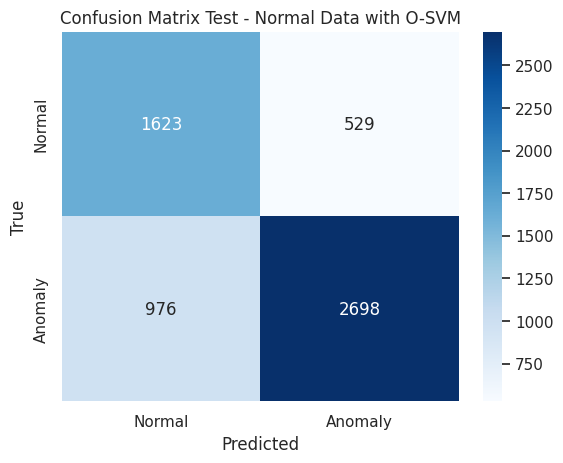


Test model trained on all data

Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.55      0.60      0.58      2152
           1       0.75      0.72      0.74      3674

    accuracy                           0.67      5826
   macro avg       0.65      0.66      0.66      5826
weighted avg       0.68      0.67      0.68      5826



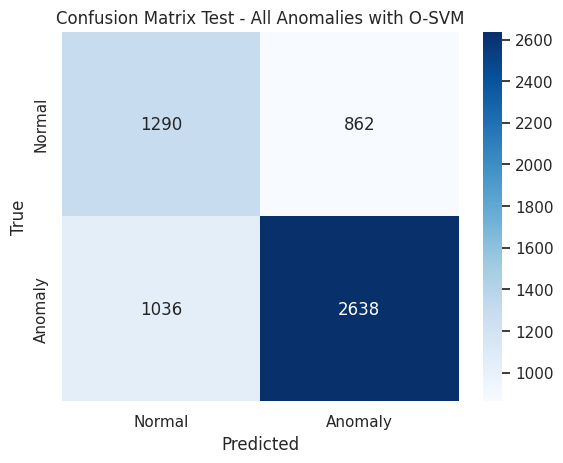


Test model trained on 10% of anomalies

Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.38      0.75      0.51      2152
           1       0.67      0.30      0.41      3674

    accuracy                           0.46      5826
   macro avg       0.52      0.52      0.46      5826
weighted avg       0.56      0.46      0.45      5826



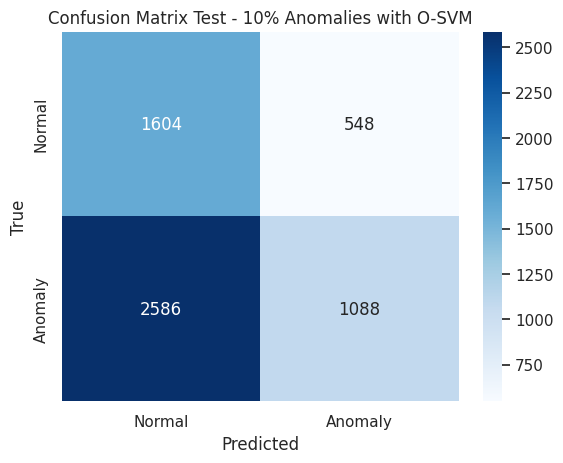

In [ ]:
# Test models with all data, no anomalies and 10% of anomalies

# Normal only
y_test_pred_normal_only = ocsvm_normal_only.predict(X_test)
y_test_pred_normal_only_binary = (y_test_pred_normal_only == -1).astype(int)

# All data
y_test_pred_all_data = ocsvm_all_data.predict(X_test)
y_test_pred_all_data_binary = (y_test_pred_all_data == -1).astype(int)

# 10% of anomalies
y_test_pred_10 = ocsvm10.predict(X_test)
y_test_pred_10_binary = (y_test_pred_10 == -1).astype(int)

print("="*50 + "\nTest model trained on normal data only")
plot_confusion_matrix(y_test, y_test_pred_normal_only_binary, "O-SVM", "Test - Normal Data")
print("\n"+"="*50+"\nTest model trained on all data")
plot_confusion_matrix(y_test, y_test_pred_all_data_binary, "O-SVM", "Test - All Anomalies")
print("\n"+"="*50+"\nTest model trained on 10% of anomalies")
plot_confusion_matrix(y_test, y_test_pred_10_binary, "O-SVM", "Test - 10% Anomalies")

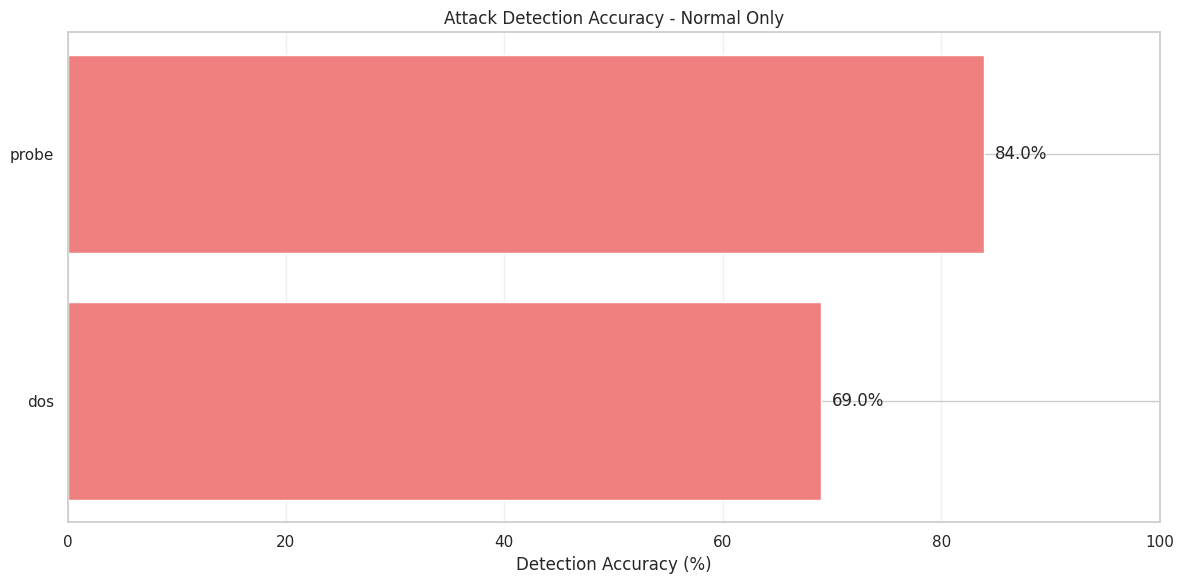


Normal Only
  dos: 69.0% accuracy (800/2577 missed)
  probe: 84.0% accuracy (176/1097 missed)


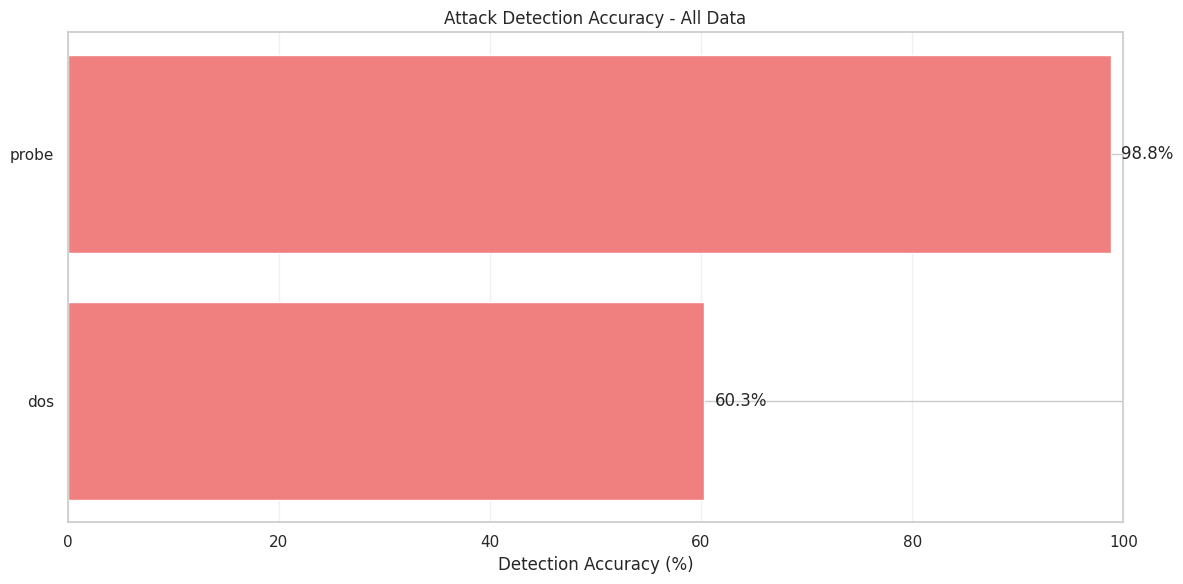


All Data
  dos: 60.3% accuracy (1023/2577 missed)
  probe: 98.8% accuracy (13/1097 missed)


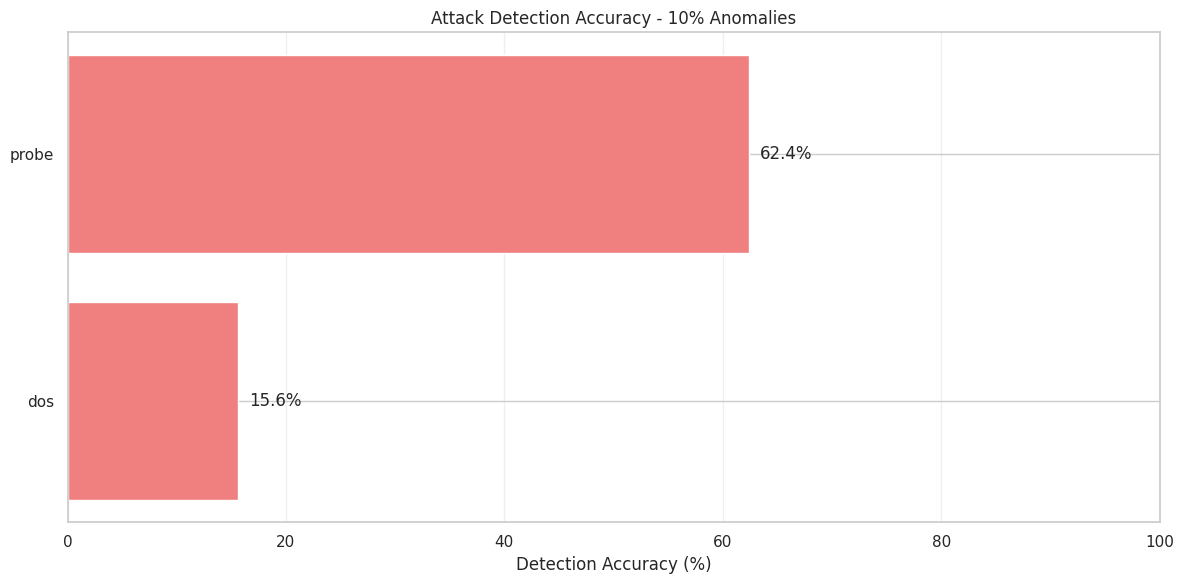


10% Anomalies
  dos: 15.6% accuracy (2174/2577 missed)
  probe: 62.4% accuracy (412/1097 missed)


In [ ]:
def plot_attack_confusion(y_true_binary, y_pred_binary, y_true_original, model_name):
    """
    Visualize attack confusion
    """
    # Create DataFrame
    df = pd.DataFrame({
        'true_binary': y_true_binary,
        'pred_binary': y_pred_binary,
        'true_attack': y_true_original
    })

    # Filter only attacks (not normal)
    attacks_df = df[df['true_binary'] == 1].copy()

    # Calculate accuracy per attack
    attack_stats = []
    for attack in attacks_df['true_attack'].unique():
        attack_samples = attacks_df[attacks_df['true_attack'] == attack]
        total = len(attack_samples)
        detected = sum(attack_samples['pred_binary'] == 1)  # Correctly flagged as anomaly
        accuracy = detected / total * 100 if total > 0 else 0

        attack_stats.append({
            'Attack': attack,
            'Total': total,
            'Detected': detected,
            'Missed': total - detected,
            'Accuracy': accuracy
        })

    df_stats = pd.DataFrame(attack_stats).sort_values('Accuracy', ascending=True)

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(df_stats['Attack'], df_stats['Accuracy'], color='lightcoral')
    plt.xlabel('Detection Accuracy (%)')
    plt.title(f'Attack Detection Accuracy - {model_name}')
    plt.xlim(0, 100)
    plt.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for bar, acc in zip(bars, df_stats['Accuracy']):
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{acc:.1f}%', va='center')

    plt.tight_layout()
    plt.show()

    # Print worst attacks
    print(f"\n{model_name}")
    for i, row in df_stats.head(3).iterrows():
        print(f"  {row['Attack']}: {row['Accuracy']:.1f}% accuracy "
              f"({row['Missed']}/{row['Total']} missed)")

# Plot for each model
plot_attack_confusion(y_test, y_test_pred_normal_only_binary, y_original_test, "Normal Only")
plot_attack_confusion(y_test, y_test_pred_all_data_binary, y_original_test, "All Data")
plot_attack_confusion(y_test, y_test_pred_10_binary, y_original_test, "10% Anomalies")

# Task 3:  Deep Anomaly Detection and Data Representation

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import copy

## Training and Validating Autoencoder with Normal data only

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)


def mixed_autoencoder_loss(x, x_recon, categ_dims, numerical_idx):
    """
    Args:
        x: original input [batch_size, num_features]
        x_recon: reconstructed input [batch_size, num_features]
        categ_dims: list of (start_idx, end_idx) tuples for one-hot encoded features
        numerical_idx: list of indices for numerical features

    Returns:
        Scalar loss value (MSE + sum of CE)
    """
    # Numerical loss (MSE)
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse = F.mse_loss(x_recon_num, x_num)

    # Categorical loss (CE for each one-hot feature)
    ce = 0
    for start, end in categ_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]
        target = torch.argmax(x_cat, dim=1)
        ce += F.cross_entropy(x_recon_cat, target)
    return mse + ce


def compute_per_sample_reconstruction_error(x, x_recon, categorical_dims, numerical_idx):
    """
    Returns a vector [batch_size] with the total reconstruction error (MSE + sum CE) for each sample
    """
    batch_size = x.shape[0]

    # Numerical error per sample
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse_per_sample = torch.mean((x_num - x_recon_num) ** 2, dim=1)

    # Categorical CE error per sample (sum across categorical features)
    ce_total = torch.zeros(batch_size, device=x.device)
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')  # shape: [batch_size]
        ce_total += ce

    # Total reconstruction error per sample
    return mse_per_sample + ce_total

def training_loop(model, train_loader, val_loader, device, optimizer, num_epochs, categorical_dims, numerical_idx, patience=10):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for (x_batch,) in train_loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            x_hat = model(x_batch)
            loss = mixed_autoencoder_loss(
                x_batch, x_hat, categorical_dims, numerical_idx
            )
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (x_batch,) in val_loader:
                x_batch = x_batch.to(device)
                x_hat = model(x_batch)
                loss = mixed_autoencoder_loss(
                    x_batch, x_hat, categorical_dims, numerical_idx
                )
                val_loss += loss.item() * x_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | "
                f"Train: {train_loss:.4f} | "
                f"Val: {val_loss:.4f}"
            )

        # Early stopping
        if epochs_without_improvement >= patience:
            print(
                f"Early stopping at epoch {epoch+1}. "
                f"Best validation loss: {best_val_loss:.4f}"
            )
            break

    model.load_state_dict(best_model_state)

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0,1)
    plt.legend()
    plt.show()

    return


In [ ]:
normal_data = df_train_preprocessed[df_train_preprocessed["binary_label"] == 0].copy()
X_normal = normal_data.drop(columns=['label', 'binary_label'])
# Convert to numpy and then to torch tensors
X_normal_np = X_normal.values.astype(np.float32)
y_normal = list(normal_data['binary_label'])

# Split into training e validation (normal data only)
X_train_normal, X_val_normal, y_train_normal, y_val_normal = train_test_split(
    X_normal_np, y_normal, test_size=0.2, random_state=42
)

all_data = df_train_preprocessed.copy()
X_all = all_data.drop(columns=['label', 'binary_label'])
X_all_np = X_all.values.astype(np.float32)
y_all = list(all_data['binary_label'])

print(f"\nTraining normal samples: {X_train_normal.shape[0]}")
print(f"Validation normal samples: {X_val_normal.shape[0]}")


Training normal samples: 10758
Validation normal samples: 2690


The device is set to: cuda
Epoch 10/100 | Train: 0.2412 | Val: 0.2938
Epoch 20/100 | Train: 0.1039 | Val: 0.1926
Epoch 30/100 | Train: 0.1232 | Val: 0.1387
Epoch 40/100 | Train: 0.0604 | Val: 0.1007
Epoch 50/100 | Train: 0.0439 | Val: 0.0931
Epoch 60/100 | Train: 0.0431 | Val: 0.1045
Epoch 70/100 | Train: 0.0537 | Val: 0.0789
Epoch 80/100 | Train: 0.0399 | Val: 0.0763
Epoch 90/100 | Train: 0.0260 | Val: 0.0658
Epoch 100/100 | Train: 0.0296 | Val: 0.0746


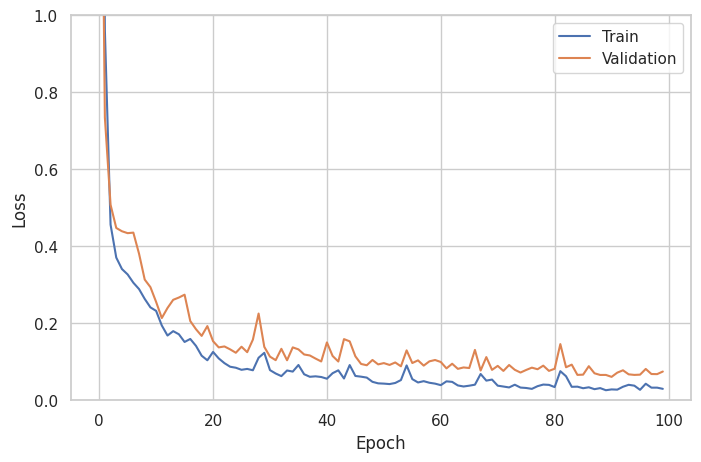

In [ ]:
#Indexes to compute the loss function based on MSE and CE for categorical features
# Get all column names
all_columns = [col for col in df_train_preprocessed.columns if col not in ['label', 'binary_label']]


# Get categorical index ranges
categorical_cols = ['protocol_type', 'service', 'flag']
categorical_dims = []
for col in categorical_cols:
    # Get all one-hot columns for this categorical feature
    one_hot_cols = [c for c in all_columns if c.startswith(col + "_")]
    if one_hot_cols:
        start_idx = all_columns.index(one_hot_cols[0])
        end_idx = start_idx + len(one_hot_cols)
        categorical_dims.append((start_idx, end_idx))

# Get numerical column indexes
numerical_idx = [i for i, col in enumerate(all_columns)
                 if not any(col.startswith(c + "_") for c in categorical_cols)]

batch_size = 64

X_train_tensor = torch.from_numpy(X_train_normal)
X_val_tensor = torch.from_numpy(X_val_normal)

train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
input_dim = X_train_normal.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")
model = Autoencoder(input_dim=input_dim, latent_dim=16).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
training_loop(model, train_loader, val_loader, device, optimizer, 100, categorical_dims, numerical_idx)



## Estimate the Reconstruction Error Threshold

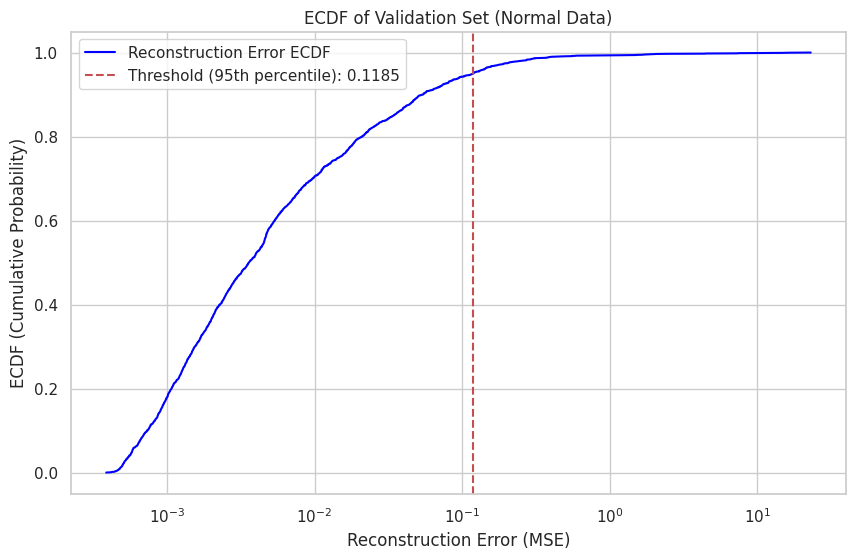

Threshold: 0.11847993


In [ ]:
# Switch to evaluation mode
model.eval()
model = model.to(device)

# Reconstruct the full dataset
with torch.no_grad():
    X_val_normal_tensor = torch.from_numpy(X_val_normal).to(device)  # ensure correct device
    X_reconstructed = model(X_val_normal_tensor)

    reconstruction_error = compute_per_sample_reconstruction_error(
        X_val_normal_tensor, X_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error = reconstruction_error.cpu().numpy()
sorted_errors = np.sort(reconstruction_error)
p = np.arange(len(sorted_errors)) / (len(sorted_errors) - 1)

plt.figure(figsize=(10,6))
plt.plot(sorted_errors, p, label="Reconstruction Error ECDF", color="blue")
threshold = np.percentile(reconstruction_error, 95)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold (95th percentile): {threshold:.4f}')

plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("ECDF (Cumulative Probability)")
plt.title("ECDF of Validation Set (Normal Data)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

print("="*50+"\nThreshold: "+str(threshold))

 ## Anomaly Detection with reconstruction error

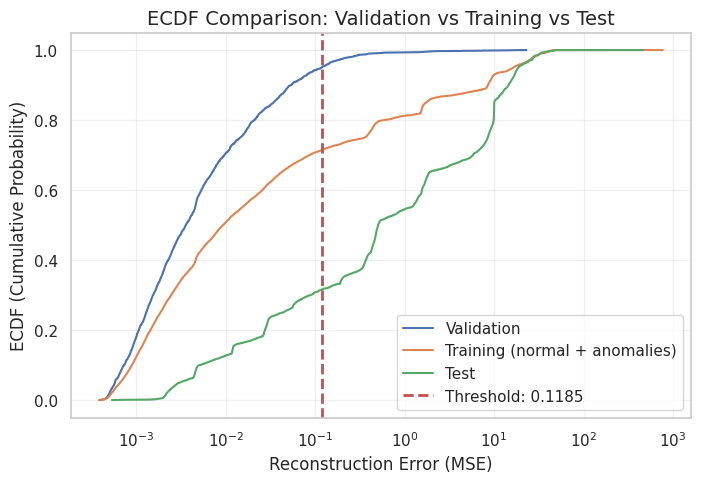


Classification Report (%s vs Ground Truth): Training
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     13448
           1       0.90      0.90      0.90      5383

    accuracy                           0.94     18831
   macro avg       0.93      0.93      0.93     18831
weighted avg       0.94      0.94      0.94     18831



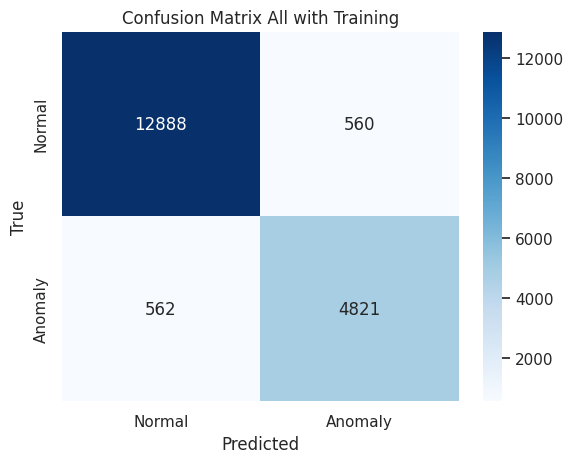


Classification Report (%s vs Ground Truth): Validation
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2690
           1       0.00      0.00      0.00         0

    accuracy                           0.95      2690
   macro avg       0.50      0.47      0.49      2690
weighted avg       1.00      0.95      0.97      2690



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


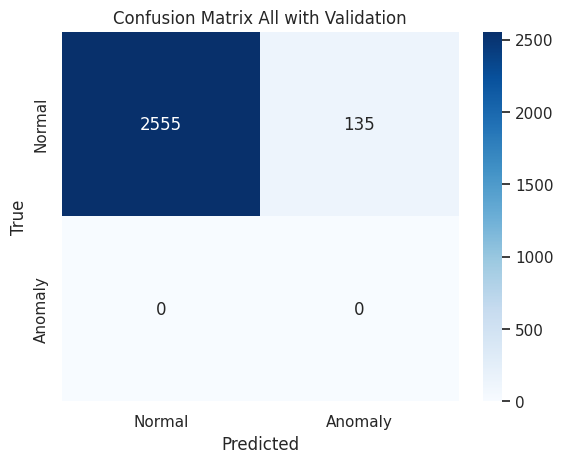


Classification Report (%s vs Ground Truth): Test
              precision    recall  f1-score   support

           0       0.73      0.63      0.68      2152
           1       0.80      0.87      0.83      3674

    accuracy                           0.78      5826
   macro avg       0.77      0.75      0.75      5826
weighted avg       0.77      0.78      0.77      5826



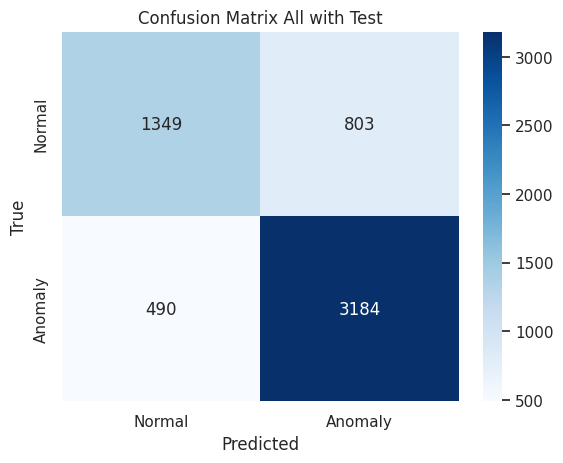

In [ ]:
def get_reconstruction_errors(model, X, device, categorical_dims, numerical_idx):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X).float().to(device)
        X_recon = model(X_tensor)
        errors = compute_per_sample_reconstruction_error(
            X_tensor, X_recon, categorical_dims, numerical_idx
        )
    return errors.cpu().numpy()

def plot_ecdf(errors, label):
    scores_sorted = np.sort(errors)
    ecdf = np.arange(1, len(scores_sorted) + 1) / len(scores_sorted)
    plt.plot(scores_sorted, ecdf, label=label)

# i) Validation
val_errors = get_reconstruction_errors(
    model, X_val_normal, device, categorical_dims, numerical_idx
)

# ii) Full training (normal + anomalies)
train_errors = get_reconstruction_errors(
    model, X_all_np, device, categorical_dims, numerical_idx
)

# iii) Test set
test_errors = get_reconstruction_errors(
    model, X_test.to_numpy(), device, categorical_dims, numerical_idx
)

print("="*70)
plt.figure(figsize=(8, 5))
plot_ecdf(val_errors, "Validation")
plot_ecdf(train_errors, "Training (normal + anomalies)")
plot_ecdf(test_errors, "Test")
plt.axvline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
plt.xlabel("Reconstruction Error (MSE)", fontsize=12)
plt.ylabel("ECDF (Cumulative Probability)", fontsize=12)
plt.title("ECDF Comparison: Validation vs Training vs Test", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.show()
plt.close()

y_pred_train = (train_errors > threshold).astype(int)
y_pred_val = (val_errors > threshold).astype(int)
y_pred_test = (test_errors > threshold).astype(int)

plot_confusion_matrix(y_all, y_pred_train, "Training", "All")
plot_confusion_matrix(y_val_normal, y_pred_val, "Validation", "All")
plot_confusion_matrix(y_test, y_pred_test, "Test", "All")

## Auto-Encoder’s bottleneck and OC-SVM


Classification Report (%s vs Ground Truth): OC_SVM
              precision    recall  f1-score   support

           0       0.77      0.54      0.64      2152
           1       0.77      0.91      0.83      3674

    accuracy                           0.77      5826
   macro avg       0.77      0.72      0.74      5826
weighted avg       0.77      0.77      0.76      5826



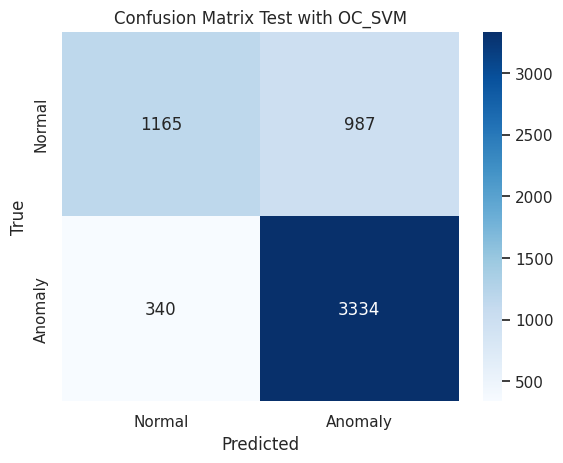

In [ ]:
# Extract latent space using the encode function
model.eval()
with torch.no_grad():
    X_train_norm_tensor = torch.from_numpy(X_train_normal).to(device)
    Z_train = model.encode(X_train_norm_tensor).cpu().numpy()

ocsvm_latent = OneClassSVM(
    kernel="rbf",
    nu=0.15,  # tried different values, this is the one with the best tradeoff between f1-score of two classes
    gamma="scale"
)

ocsvm_latent.fit(Z_train)

# Prepare test tensor
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.to_numpy()).float().to(device)
    Z_test = model.encode(X_test_tensor).cpu().numpy()

# Predict
y_pred_ocsvm = ocsvm_latent.predict(Z_test)
y_pred_ocsvm = (y_pred_ocsvm == -1).astype(int)

plot_confusion_matrix(y_test, y_pred_ocsvm, 'OC_SVM', "Test")

##  PCA and OC-SVM:

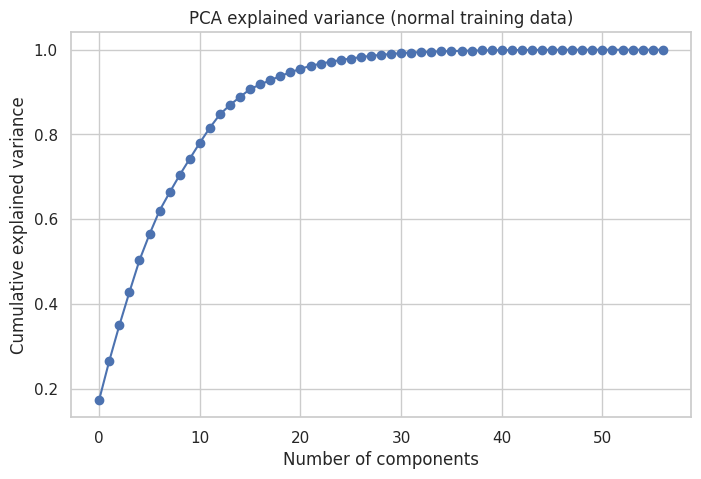

Variance is expressed mostly (over 95%) by 21 components


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(



Classification Report (%s vs Ground Truth): OC-SVM on the PCA space
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      2152
           1       0.79      0.85      0.82      3674

    accuracy                           0.77      5826
   macro avg       0.75      0.74      0.74      5826
weighted avg       0.76      0.77      0.76      5826



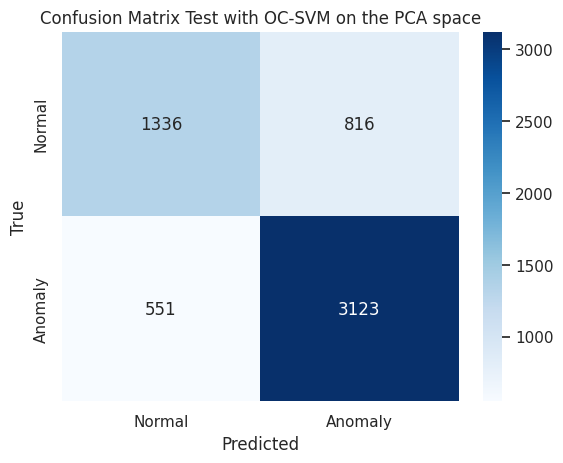

In [ ]:
pca_full = PCA().fit(X_train_normal)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot elbow
plt.figure(figsize=(8,5))
plt.plot(explained_variance, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance (normal training data)")
plt.grid(True)
plt.show()

n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Variance is expressed mostly (over 95%) by {n_components} components")

# PCA with "important" components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_normal)
X_test_pca = pca.transform(X_test)

# OC-SVM
ocsvm_pca = OneClassSVM(
    kernel="rbf",
    nu=0.15,
    gamma="scale"
)

ocsvm_pca.fit(X_train_pca)
y_pred_pca = ocsvm_pca.predict(X_test_pca)
y_pred_pca = (y_pred_pca == -1).astype(int)

plot_confusion_matrix(y_test, y_pred_pca, 'OC-SVM on the PCA space', "Test")

#  Task 4: Unsupervised Anomaly Detection and Interpretation

In [ ]:
def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.

    Parameters:
    - X : ndarray of shape (n_samples, n_features)
        The input data.
    - labels : array-like of shape (n_samples,)
        Cluster labels assigned to each point. Should not contain -1.

    Returns:
    - sse : float
        The SSE (sum of squared distances to cluster centroids).
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels):

    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if(-1 in distinct_labels):
        n_clusters -=1

    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)

    fig, ax = plt.subplots(figsize=(8, 6))

    y_lower = 10

    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster",i,"size",len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples



    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend(loc="lower right")
    plt.show()
    plt.close()
    return

def plot_tsne(X, labels, title, perplexity=30):

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=perplexity,
        init='random',
        learning_rate='auto'
    )

    X_tsne = tsne.fit_transform(X)

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne,
        x='TSNE1',
        y='TSNE2',
        hue='label',
        palette='tab10',
        alpha=0.7,
        s=30
    )

    plt.title(f"{title} (perplexity={perplexity})")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()


###KMeans and Silhouette

K-Means SSE: 469794.43
K-Means Silhouette Score: 0.34
For n_clusters = 4 The average silhouette_score is : 0.338084407566748
cluster 0 size 13017
cluster 1 size 1777
cluster 2 size 1932
cluster 3 size 2105


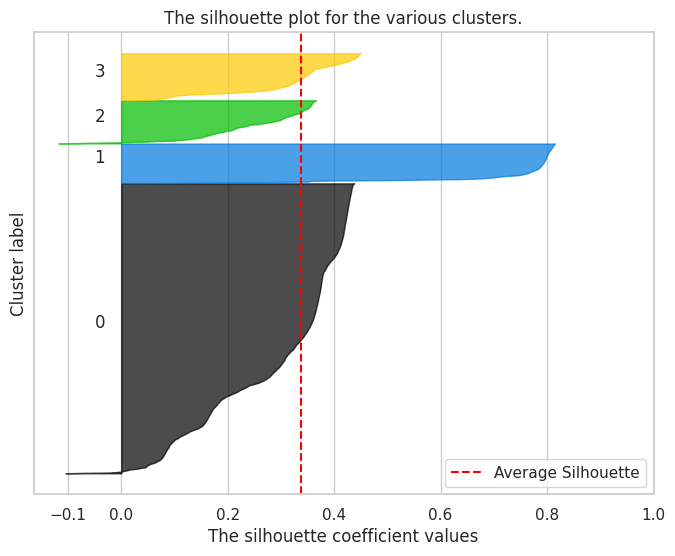


Classification Report (%s vs Ground Truth): K-Means
              precision    recall  f1-score   support

           0       0.73      0.97      0.83     13448
           1       0.57      0.10      0.17      5383

    accuracy                           0.72     18831
   macro avg       0.65      0.53      0.50     18831
weighted avg       0.68      0.72      0.64     18831



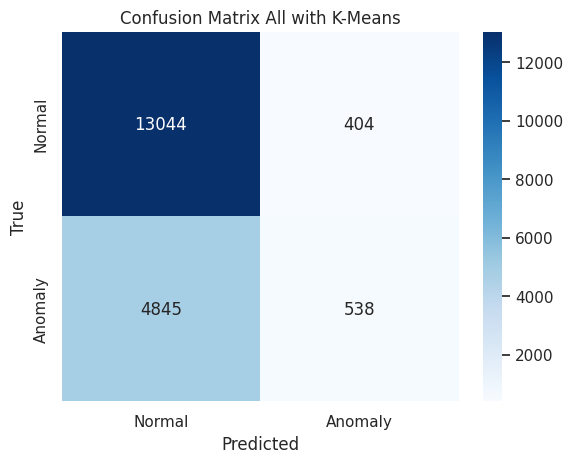

label          normal   dos  probe  r2l
Cluster_label                          
0               11455   233   1148  181
1                  37  1657     83    0
2                 551   343   1038    0
3                1405   680     20    0

Silhouette for each cluster:
Cluster 0: 0.2987
Cluster 1: 0.7397
Cluster 2: 0.2525
Cluster 3: 0.3209


In [ ]:
# Create clusters with KMeans
X_train = X_all.copy()
y_train = y_all.copy()
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train)
kmeans_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

sse_avg = compute_sse(X_train,kmeans_centers,kmeans_labels)
silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

print(f"K-Means SSE: {sse_avg:.2f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels)


# Compute distance to assigned cluster center
_, distances_center = pairwise_distances_argmin_min(X_train, kmeans.cluster_centers_)
# Set a threshold for anomaly 100 - anomaloues percenties
threshold = np.percentile(distances_center, 100-int(0.05*100))
y_pred_binary_kmeans = [1 if distance > threshold else 0 for distance in distances_center]

plot_confusion_matrix(y_train, y_pred_binary_kmeans, "K-Means", "All")
df_clusters = pd.DataFrame({
    "Cluster_label": kmeans_labels,
    "label": y_original_train,
    "binary_label": y_train}
)
label_counts = df_clusters.groupby('Cluster_label')['label'].value_counts().unstack(fill_value=0)

cols = label_counts.columns.tolist()
if 'normal' in cols:
    cols.remove('normal')
    cols = ['normal'] + cols
label_counts = label_counts[cols]

print(label_counts)

print("\nSilhouette for each cluster:")
for cl, sil in clusters_silhouettes.items():
    print(f"Cluster {cl}: {sil:.4f}")


### T-SNE

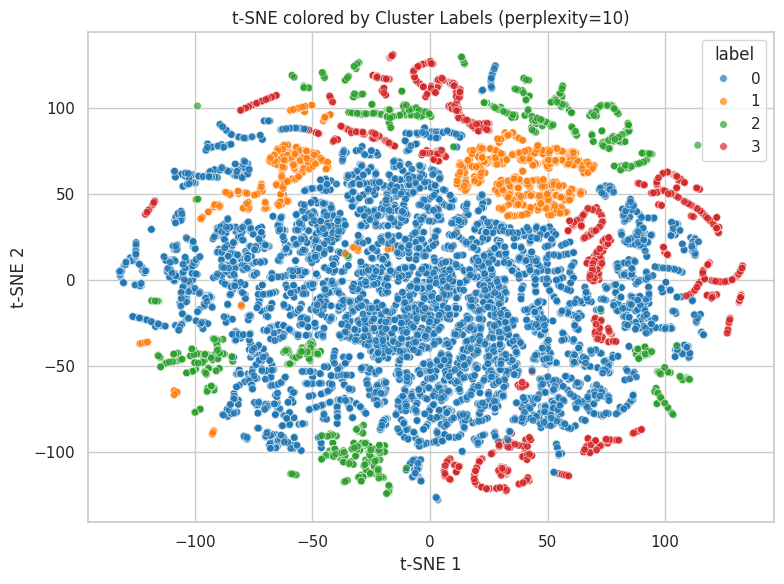

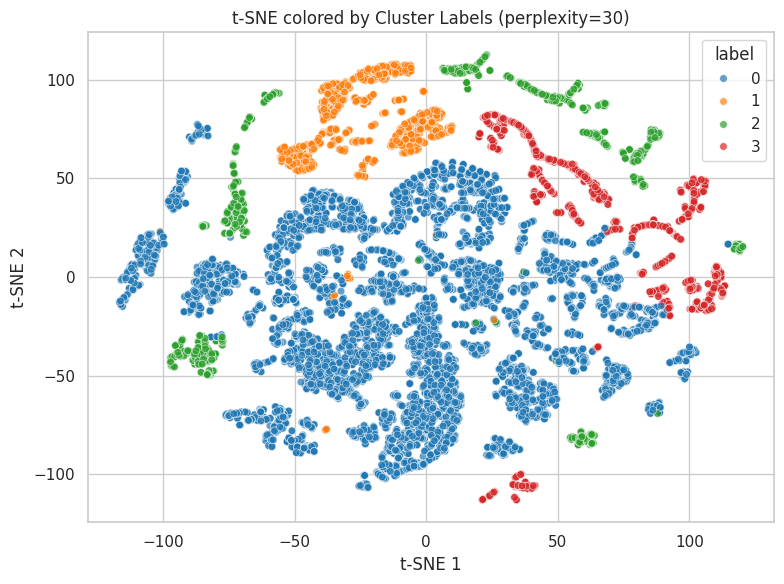

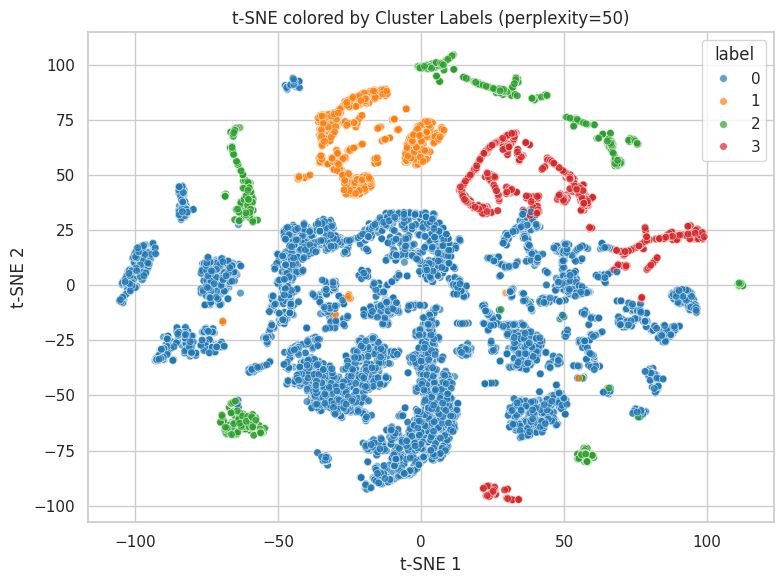

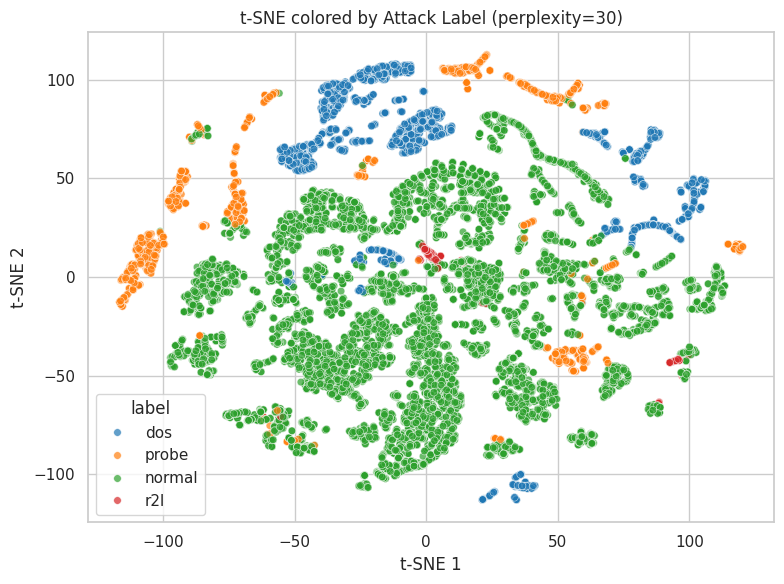

In [ ]:
# Plot with t-SNE
for p in [10,30,50]:
    plot_tsne(
    X_train,
    kmeans_labels,
    title='t-SNE colored by Cluster Labels',
    perplexity=p
)

# Plot t-SNE with perplexity = 30 (best one)
plot_tsne(
    X_train,
    y_original_train,
    title='t-SNE colored by Attack Label',
    perplexity=30
)

### DB-Scan

In [ ]:
# Try to find a pure cluster
ks = [4, 5, 6, 7, 8, 9, 10, 11, 12]
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train)

    print(f"\nk = {k}")
    n_anomalies = []
    for cluster_id in range(k):
        idx = labels == cluster_id
        cluster_labels = np.asarray(y_train)[idx]
        n_normals = np.sum(cluster_labels == 0)
        n_anom = np.sum(cluster_labels == 1)
        n_anomalies.append(n_anom)
        print(f"  Cluster {cluster_id}: normals={n_normals}, anomalies={n_anom}")
    if 0 in n_anomalies: break



k = 4
  Cluster 0: normals=11455, anomalies=1562
  Cluster 1: normals=37, anomalies=1740
  Cluster 2: normals=551, anomalies=1381
  Cluster 3: normals=1405, anomalies=700

k = 5
  Cluster 0: normals=11288, anomalies=1504
  Cluster 1: normals=37, anomalies=1740
  Cluster 2: normals=549, anomalies=1381
  Cluster 3: normals=1404, anomalies=700
  Cluster 4: normals=170, anomalies=58

k = 6
  Cluster 0: normals=8955, anomalies=1113
  Cluster 1: normals=33, anomalies=1739
  Cluster 2: normals=2336, anomalies=595
  Cluster 3: normals=1411, anomalies=501
  Cluster 4: normals=170, anomalies=58
  Cluster 5: normals=543, anomalies=1377

k = 7
  Cluster 0: normals=9387, anomalies=202
  Cluster 1: normals=38, anomalies=1740
  Cluster 2: normals=1898, anomalies=1320
  Cluster 3: normals=1407, anomalies=498
  Cluster 4: normals=170, anomalies=58
  Cluster 5: normals=548, anomalies=1378
  Cluster 6: normals=0, anomalies=187

k = 8
  Cluster 0: normals=9311, anomalies=315
  Cluster 1: normals=36, anom

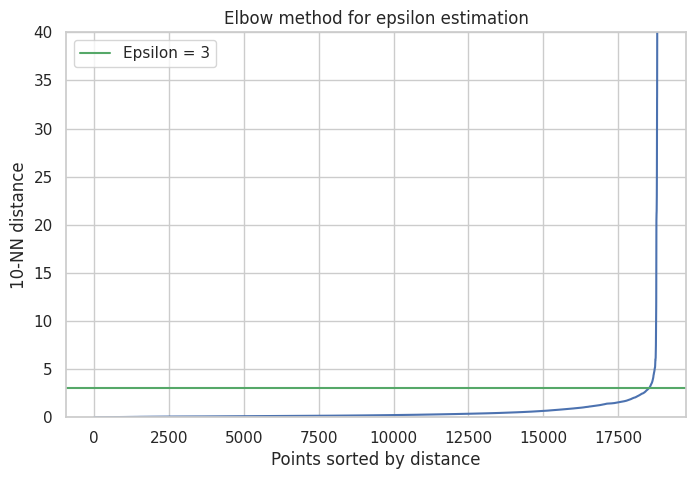

In [ ]:
# DB-Scan
from sklearn.neighbors import NearestNeighbors
import matplotlib.ticker as ticker

min_points = 10 # Trying different k we find with k=8 a cluster with only 10 normal points
neighbors = NearestNeighbors(n_neighbors=min_points)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.axhline(3, linestyle='-', color='g', label='Epsilon = 3')
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_points}-NN distance")
ax = plt.gca()
ax.set_ylim(0, 40)
plt.legend()
plt.title("Elbow method for epsilon estimation")
plt.grid(True)
plt.show()
plt.close()

In [ ]:
# Using elbow rule
epsilon = 3.0

dbscan = DBSCAN(eps=epsilon, min_samples=min_points)
dbscan_labels = dbscan.fit_predict(X_train)

df_dbscan = pd.DataFrame({
    "dbscan_cluster": dbscan_labels,
    "attack_label": y_original_train
})

print(df_dbscan[df_dbscan["dbscan_cluster"] == -1]["attack_label"].value_counts())


attack_label
normal    169
probe      24
r2l         4
dos         1
Name: count, dtype: int64
